In [1]:
from __future__ import division
import numpy as np
from numpy import fft
from scipy import signal, ndimage, misc, fftpack
import bitarray
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import reedsolo

import time
import serial
%matplotlib inline

In [2]:
IMG_DIR = 'Images/'

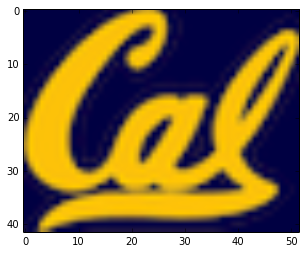

In [3]:
img = ndimage.imread(IMG_DIR+'calBlue.tiff')
plt.imshow(img)
plt.show()

In [4]:
def RGB2YCbCr(RGB):
    # Full range RGB/YCbCr conversion
    A = np.array([[[ 0.299,  0.587,  0.114],
                   [-0.169, -0.331,  0.500],
                   [ 0.500, -0.419, -0.081]]])
    
    YCbCr = np.dot(A, RGB.reshape((-1, 3)).T).T.reshape(RGB.shape) + np.array([0, 128, 128]).reshape((1,1,3))
    return YCbCr[:,:,0], YCbCr[:,:,1], YCbCr[:,:,2]

def YCbCr2RGB(y, cb, cr):
    # Full range RGB/YCbCr conversion
    B = np.array([[1.000,  0.000,  1.400],
                  [1.000, -0.343, -0.711],
                  [1.000,  1.765,  0.000]])
    
    YCbCr = np.dstack((y, cb-128, cr-128))
    return np.dot(B, YCbCr.reshape((-1, 3)).T).T.reshape(YCbCr.shape)

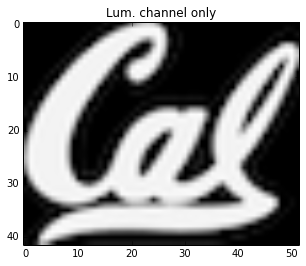

7.41 199.515


In [5]:
# Proof of concept of color space conversion
imgL, imgCb, imgCr = RGB2YCbCr(img)
plt.imshow(imgL, cmap='gray')
plt.title("Lum. channel only")
plt.show()

print np.min(imgL), np.max(imgL)

In [6]:
def genZigZag(n):
    # Used to calculate the "zigzag" traversal used to flatten JPEG blocks
    # Ascending
    swap = 0
    for idxSum in range(n):
        x = 0 if swap else idxSum
        y = idxSum if swap else 0
        if swap:
            while y >= 0:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= 0:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
    
    #Decending
    floor = 1
    for idxSum in range(n, 2*n-1):
        x = floor if swap else n-1
        y = n-1 if swap else floor
        if swap:
            while y >= floor:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= floor:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
        floor += 1

def DCT_2D(x):
    return fftpack.dct(fftpack.dct(x, norm='ortho', axis=0), norm='ortho', axis=1)

def IDCT_2D(x):
    return fftpack.idct(fftpack.idct(x, norm='ortho', axis=0), norm='ortho', axis=1)

def rescale(img):
    if np.min(img) < 0:
        img = img - np.min(img)
    if np.max(img) > 255:
        img = np.divide(img, np.max(img)) * 255
    return img

def clip(img, minval=0, maxval=255):
    return np.clip(img, minval, maxval, img)

def getLim(img):
    return (np.min(img), np.max(img))

def PSNR(im_truth, im_test, maxval=255.):
    mse = np.linalg.norm(im_truth.astype(np.float64) - im_test.astype(np.float64))**2 / np.prod(np.shape(im_truth))
    return 10 * np.log10(maxval**2 / mse)

def isGrayscale(img, THRESH=25.):
    return PSNR(img, np.dstack((img[:,:,0], img[:,:,0], img[:,:,0]))) > THRESH

In [7]:
class JPEGlib(object):
    # Standard-specified Luminosity Table
    QL = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
                   [12, 12, 14, 19,  26,  58,  60,  55],
                   [14, 13, 16, 24,  40,  57,  69,  56],
                   [14, 17, 22, 29,  51,  87,  80,  62],
                   [18, 22, 37, 56,  68, 109, 103,  77],
                   [24, 35, 55, 64,  81, 104, 113,  92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])
    
    # Standard-specified Chrominance Table
    QC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]])

    QN = np.ones((8,8))
    
    
    def __init__(self, raw, qtable, QF=50, dims=None, rescale=False):
        assert 1 <= QF < 100, "Quality Factor (QF) must be 1 <= QF < 100"
        if QF > 50:
            alpha = 2 - QF/50
        else:
            alpha = 50/QF
        
        self.raw = raw
        self.qtable = qtable*alpha
        self.dims = raw.shape if dims is None else dims
        self.zstride = list(genZigZag(8))
        self.linstride = list(range(64))
        self.rescale = rescale


class JPEG(JPEGlib):
    def __init__(self, raw, qtable, QF):
        super(JPEG, self).__init__(raw, qtable, QF)

    def process(self, inarr=None, dims=None):
        if inarr is None:
            inarr = self.raw
        if dims is None:
            dims = self.dims
        out = np.zeros(((dims[0]//8)*(dims[1]//8), 64))
        
        for i in xrange(0, dims[0], 8):
            for j in xrange(0, dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                block = DCT_2D(block)
                block = np.round(np.divide(block, self.qtable))
                for k, z in zip(self.linstride, self.zstride):
                    out[(dims[1]*i//64)+(j//8), k] = block[z[0], z[1]]
        return out

class IJPEG(JPEGlib):
    def __init__(self, raw, qtable, QF, dims, rescale=True):
        super(IJPEG, self).__init__(raw, qtable, QF, dims, rescale)

    def process(self, inarr=None, dims=None):
        if inarr is None:
            inarr = self.raw
        if dims is None:
            dims = self.dims
        out = np.zeros(self.dims)
        block = np.empty((8,8))

        for i in xrange(0, dims[0], 8):
            for j in xrange(0, dims[1], 8):
                for k, z in zip(self.linstride, self.zstride):
                    block[z[0], z[1]] = inarr[(dims[1]*i//64)+(j//8), k]
                block = np.multiply(block, self.qtable)
                block = IDCT_2D(block)
                out[i:i+8, j:j+8] = block

        return rescale(out) if self.rescale else out

In [8]:
# Proof of concept of JPEG class
imgIn = imgL[:520,:768]
j = JPEG(imgIn, qtable=JPEG.QL, QF=95)
imgProc = j.process()
jI = IJPEG(imgProc, JPEG.QL, QF=95, dims=imgIn.shape, rescale=True)
imgOut = jI.process()


plt.figure()
plt.imshow(imgIn, cmap='gray')
plt.figure()
plt.imshow(imgOut.astype(np.uint8), cmap='gray')
plt.figure()
plt.imshow(imgIn - imgOut, cmap='gray')
plt.show()

print np.min(imgIn), np.max(imgOut)
print np.min(imgOut), np.max(imgOut)
print np.min(imgProc[:,0]), np.max(imgProc[:,0])
print np.min(imgProc[:,1:]), np.max(imgProc[:,1:])

ValueError: operands could not be broadcast together with shapes (8,4) (8,8) 

In [9]:
def RiFi_preprocess(img, quality):
    # Calculating image shape to be even multiples of 8.
    targetsize = img.shape[0] + (8 - (img.shape[0] % 8)) % 8, \
                 img.shape[1] + (8 - (img.shape[1] % 8)) % 8
    subsize = targetsize[0]//2, targetsize[1]//2                 # subsampling by 2x2
    subsize = subsize[0] + (8 - (subsize[0] % 8)) % 8, \
              subsize[1] + (8 - (subsize[1] % 8)) % 8
    
    # RGB -> YCbCr and subsampling (is it better to 0 pad instead?)
    imgY, imgCb, imgCr = RGB2YCbCr(img)
    imgY = signal.resample(signal.resample(imgY, targetsize[0], axis=0), targetsize[1], axis=1)
    imgCb = signal.resample(signal.resample(imgCb, subsize[0], axis=0), subsize[1], axis=1)
    imgCr = signal.resample(signal.resample(imgCr, subsize[0], axis=0), subsize[1], axis=1)
    
    # JPEG DCT transformation, quatization
    bitsY = JPEG(imgY, qtable=JPEGlib.QN, QF=quality).process()
    bitsCb = JPEG(imgCb, qtable=JPEGlib.QN, QF=quality).process()
    bitsCr = JPEG(imgCr, qtable=JPEGlib.QN, QF=quality).process()
    return targetsize, subsize, bitsY, bitsCb, bitsCr, getLim(img[:,:,0]), getLim(img[:,:,1]), getLim(img[:,:,2])
    
def RiFi_postprocess(bitsY, bitsCb, bitsCr, targetsize, subsize, originalsize, quality, Rlim, Glim, Blim):
    # Use JPEG class to convert bitarrays back to images
    imgY = IJPEG(bitsY, qtable=JPEGlib.QN, QF=quality, dims=targetsize).process()
    imgCb = IJPEG(bitsCb, qtable=JPEGlib.QN, QF=quality, dims=subsize).process()
    imgCr = IJPEG(bitsCr, qtable=JPEGlib.QN, QF=quality, dims=subsize).process()
    
    # Reconstruct RGB image in original dimensions
    imgY = signal.resample(signal.resample(imgY, originalsize[0], axis=0), originalsize[1], axis=1)
    imgCb = signal.resample(signal.resample(imgCb, originalsize[0], axis=0), originalsize[1], axis=1)
    imgCr = signal.resample(signal.resample(imgCr, originalsize[0], axis=0), originalsize[1], axis=1)
    imgRecon = YCbCr2RGB(imgY, imgCb, imgCr)

    # Rescale image and cast to uint8
    imgRecon[:,:,0] = clip(imgRecon[:,:,0], minval=Rlim[0], maxval=Rlim[1])
    imgRecon[:,:,1] = clip(imgRecon[:,:,1], minval=Glim[0], maxval=Glim[1])
    imgRecon[:,:,2] = clip(imgRecon[:,:,2], minval=Blim[0], maxval=Blim[1])
    return imgRecon.astype(np.uint8)

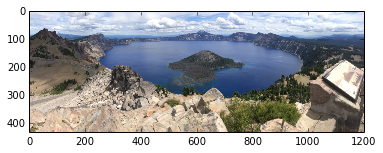

In [10]:
img = ndimage.imread(IMG_DIR+'createrLake.tiff')
plt.imshow(img)
plt.show()

In [11]:
print isGrayscale(img)

False


In [12]:
tsize, ssize, Y, Cb, Cr, Rlim, Glim, Blim = RiFi_preprocess(img, 2)

### TRANSMIT: img.shape[:2], tsize, ssize, Y, Cb, Cr ###

imgRecon = RiFi_postprocess(Y, Cb, Cr, tsize, ssize, (img.shape[0], img.shape[1]), 2, Rlim, Glim, Blim)

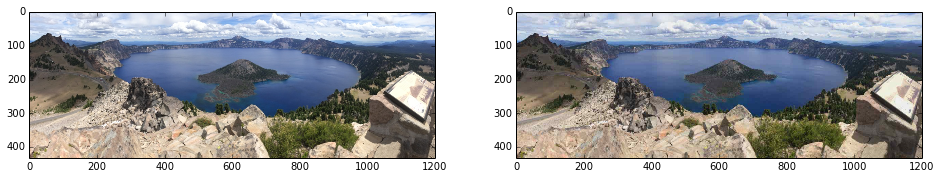

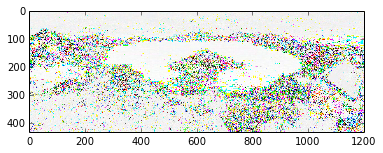

PSNR:  27.3572926017
(432, 1200, 3)
(432, 1200, 3)


In [13]:
width, height = plt.figaspect(0.25)
fig = plt.figure(figsize=(width,height))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(imgRecon)

plt.figure()
plt.imshow(img.astype(np.float64) - imgRecon.astype(np.float64))
plt.show()

print 'PSNR: ', PSNR(img, imgRecon)
print img.shape
print imgRecon.shape

In [14]:
misc.imsave(IMG_DIR+'createrLake_recon.jpg', imgRecon)

In [21]:
import Encoding
import Transmission
import pyaudio
reload(Encoding)
reload(Transmission)

def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

print 
e = Encoding.encode(Y, Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
a = len(e)
# _ = Transmission.testTransmit(e)

e = Encoding.encode(Cb, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
b = len(e)
# Transmission.testTransmit(e)

e = Encoding.encode(Cr, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
c = len(e)
# Transmission.testTransmit(e)

print (a+b+c)//8
print img.shape[0]*img.shape[1]*3

0 HDA Intel PCH: HDMI 0 (hw:0,3)
1 HDA Intel PCH: HDMI 1 (hw:0,7)
2 HDA Intel PCH: HDMI 2 (hw:0,8)
3 USB PnP Sound Device: Audio (hw:1,0)
4 hdmi
5 pulse
6 default

63739
1555200


In [22]:
dusb_in =3
dusb_out =3
d_in = 5
d_out = 5

In [23]:
reload(Transmission)
reload(Encoding)
rs = reedsolo.RSCodec(30)
e = Encoding.encode(Cr[:10], Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
p = Transmission.packetize(e,rs)
f = Transmission.findPackets(Transmission.NRZI2NRZ(p), rs)

In [24]:
print e
print f

bitarray('0001111111111011000111110100111000000011000000010000000000000000000011001111111111011001')
[]


In [25]:
# HEADER FORMAT
# [IMG_FLAG, img.shape, tsize, ssize, Rlim, Glim, Blim]
def magic(filename, dout, quality=2):
    MAX_BYTES = 18000
    IM_FLAG = None
    img = ndimage.imread(filename)
    if img.shape[0]*img.shape[1]*img.shape[2] < MAX_BYTES:
        # send with no processing
        IM_FLAG = 0
        
        # encode data
        dataArr = [IM_FLAG]+list(img.shape[:2])
        eData = bitarray.bitarray()
        for val in dataArr:
            binval = bin(val)[2:].zfill(16)
            eData += bitarray.bitarray(binval)
        eR = Encoding.encode(img[:,:,0], Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
        eG = Encoding.encode(img[:,:,1], Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
        eB = Encoding.encode(img[:,:,2], Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
        print dataArr
        print eData
        print eR
        
        # send data
        raw_input("Send data with flag=0?... ")
        Transmission.transmit(eData, dout)
        Transmission.transmit(eR, dout)
        Transmission.transmit(eG, dout)
        Transmission.transmit(eB, dout)
        
    elif isGrayscale(img):
        # send only Y channel w/ JPEG
        IM_FLAG = 1
        tsize, ssize, bitsY, bitsCb, bitsCr, Rlim, Glim, Blim = RiFi_preprocess(img, quality)
        eY = Encoding.encode(bitsY, Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
        ds_ratio = MAX_BYTES*8/len(eY)
        print len(eY)//8
        
        if ds_ratio < 1.:
            img_ds = signal.resample
        
        # encode metadata
        dataArr = [IM_FLAG, quality]+list(img.shape[:2])+list(tsize)+[0,0]+list(Rlim)+list(Glim)+list(Blim)
        eData = bitarray.bitarray()
        for val in dataArr:
            binval = bin(val)[2:].zfill(16)
            eData += bitarray.bitarray(binval)
        print dataArr
        
        # send data
        raw_input("Send data with flag=1?... ")
        Transmission.Transmit(eData)
        Transmission.Transmit(eY)
        
    else:
        # use JPEG compression
        IM_FLAG = 2
        tsize, ssize, bitsY, bitsCb, bitsCr, Rlim, Glim, Blim = RiFi_preprocess(img, quality)
        
        # encode metadata
        dataArr = [IM_FLAG, quality]+list(img.shape[:2])+list(tsize)+list(ssize)+list(Rlim)+list(Glim)+list(Blim)
        eData = bitarray.bitarray()
        for val in dataArr:
            binval = bin(val)[2:].zfill(16)
            eData += bitarray.bitarray(binval)
        print dataArr
        
        eData = Encoding.encode(dataArr)
        eY = Encoding.encode(bitsY)
        eCb = Encoding.encode(bitsCb)
        eCr = Encoding.encode(bitsCr)
        
        # send data
        input("Send data with flag=2?... ")
        Transmission.testTransmit(eData)
        Transmission.testTransmit(eY)
        Transmission.testTransmit(eCb)
        Transmission.testTransmit(eCr)

In [ ]:
import Queue
import serial
try:
    try:
        s = serial.Serial(port='/dev/ttyUSB0')
    except:
        s = serial.Serial(port='/dev/ttyUSB1')
    s.setDTR(0)
    #s = serial.Serial(port='COM3')
    #s.setDTR(0)

    Qin = Queue.Queue()
    cQin = Queue.Queue()

    p = pyaudio.PyAudio()
    fs_usb = 48e3

    Transmission.record_audio(Qin, cQin, p, fs_usb, dusb_in, 512)
    

except NameError:
    print 'ooga booga'
time.sleep(2)
cQin.put('EOT')
time.sleep(2)
p.terminate()
s.close()

recorded = []
while not (Qin.empty()):
    recorded.append(Qin.get())

data = np.array(recorded).flatten()
np.save('multiD2', data)

In [ ]:
import operator
print data
reload(Transmission)
reload(Encoding)
MULTI = 0
plt.plot(data)
if MULTI:
    dd = Transmission.nc_mafsk1200Demod(data)
    plloc = Transmission.mafsk2crossings(dd)
    bindex = Transmission.mPLL(plloc)
    locs = Transmission.mafsk2barr(dd, indii = bindex)
    samples = bitarray.bitarray([True if x == 1 else False for x in locs])
else:
    demod = Transmission.nc_afsk1200Demod(data, fs_usb)
    idx = Transmission.PLL(demod, fs=fs_usb)
    samples = bitarray.bitarray([bit >= 0 for bit in np.array(demod)[idx.astype(int)]])
bits = Transmission.NRZI2NRZ(samples)
packets = Transmission.findPackets(bits, reedsolo.RSCodec(30))
decoded = reduce(operator.add, packets)
# print decoded == eBits
# return decoded

In [ ]:
w = 100000
plt.plot(np.abs(dd[0])[w:w+500])
plt.figure()
plt.plot(np.abs(dd[1])[w:w+500])
plt.figure()
plt.plot(np.abs(dd[2])[w:w+500])
plt.figure()
plt.plot(np.abs(dd[3])[w:w+500])


In [ ]:
print len(packets)
print len(decoded)/8
# print decoded.to01() == "01100110"*1000
print decoded[:100]
print decoded == Encoding.encode(Y, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)


In [ ]:
d = Encoding.decode(decoded.__iter__(), Encoding.huffmanRootLuminanceDC, Encoding.huffmanRootLuminanceAC)
e = Encoding.huffmanRootChrominanceDC, Encoding.huffmanRootChrominanceAC

In [ ]:
magic(IMG_DIR+'calBlue.tiff', dusb_in)

In [ ]:
try:
    s = serial.Serial(port='/dev/ttyUSB0')
except:
    s = serial.Serial(port='/dev/ttyUSB3')
s.setDTR(0)